### **1. Introduction & Motivation**

**Recap from Project 7**
In the last project, we worked with the **Human Activity Recognition (HAR)** dataset.  

- We built **Recurrent Neural Networks (RNNs)** to classify *what activity a person was doing* based on sensor sequences.  
- The task was a **classification problem**:  
  - Input: a sequence of accelerometer/gyroscope readings.  
  - Output: one of 6 activity labels (e.g., *Walking*, *Standing*, *Laying*).  

👉 In other words, the RNN compressed a sequence into a **class decision**.

**New Challenge in Project 8:**
Now, we shift our focus from **classification** to **forecasting**.  

- **Dataset:** Daily minimum temperatures in Melbourne (1981–1990).  
- **Task:** Given the last few days of temperature, predict the **next day’s temperature**.  

This makes our problem a **regression/forecasting problem** instead of classification.

**Why Forecasting Matters**
Time series forecasting is central to many applications:

- 🌦️ Weather prediction  
- ⚡ Energy demand forecasting  
- 📈 Stock price and financial forecasting  
- 🏭 Industrial sensor monitoring  

Unlike Project 7, where sequences led to *discrete classes*, here sequences lead to *continuous future values*.

**Key Shift in Thinking**

- **Project 7:**  
  $X = [x_1, x_2, \dots, x_T] \;\;\longrightarrow\;\; y \in \{\text{Walking},\; \text{Sitting},\; \dots\}$

- **Project 8:**  
  $X = [T_1, T_2, \dots, T_n] \;\;\longrightarrow\;\; y = T_{n+1}$

So, the sequence of past values is used to *predict the very next value*.

**Intuition**
Imagine you are checking the weather:  

- If it’s been **cold for 3 days**, you expect tomorrow to also be cold.  
- If it’s been **warming up for a week**, you expect tomorrow to be warmer.  

That’s exactly what our model will learn: *patterns in the past that help forecast the future*.

**Reflection Question**
👉 **How does forecasting differ from classification?**  
- Think about the **output type** (continuous vs. categorical).  
- Think about the **goal** (predicting the future vs. recognizing a current state).

---

### **2. Explore the Dataset (EDA)**

**Why Explore the Data?**
Before building any predictive model, we need to **understand the dataset**:

- What does the time series look like?  
- Are there **trends or seasonal cycles**?  
- How much **day-to-day variability** is there?  

👉 These questions guide our modeling. For example:
- If seasonality is strong, our model needs enough history (window size) to capture it.
- If the series has no structure, then learning will be much harder.

**Step 0: Load and Inspect the Data**
The dataset is stored in a CSV file with two columns:

- **Date** — formatted as `MM/DD/YY` (e.g., `01/13/81`).  
- **Temp** — daily minimum temperature in °C.  

We will parse the date correctly, set it as the index, and check for any missing values.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Load raw CSV
df = pd.read_csv("dataset/1_Daily_minimum_temps.csv")

# Parse Date (format is MM/DD/YY, e.g., "01/13/81")
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%y")

# Set Date as index
df.set_index("Date", inplace=True)

# Ensure Temp is numeric
df["Temp"] = pd.to_numeric(df["Temp"], errors="coerce")

# Basic info
print("Shape:", df.shape)
print(df.head(20))
print(df["Temp"].describe())

# Check for missing values
print("Missing values:", df["Temp"].isna().sum())


Shape: (3650, 1)
            Temp
Date            
1981-01-01  20.7
1981-01-02  17.9
1981-01-03  18.8
1981-01-04  14.6
1981-01-05  15.8
1981-01-06  15.8
1981-01-07  15.8
1981-01-08  17.4
1981-01-09  21.8
1981-01-10  20.0
1981-01-11  16.2
1981-01-12  13.3
1981-01-13  16.7
1981-01-14  21.5
1981-01-15  25.0
1981-01-16  20.7
1981-01-17  20.6
1981-01-18  24.8
1981-01-19  17.7
1981-01-20  15.5
count    3647.000000
mean       11.186647
std         4.061671
min         0.000000
25%         8.300000
50%        11.000000
75%        14.000000
max        26.300000
Name: Temp, dtype: float64
Missing values: 3


**Step 1: Full 10-Year View**

Now let’s plot the entire dataset (1981–1990).  
Here, the x-axis is years and the y-axis is daily minimum temperature (°C).

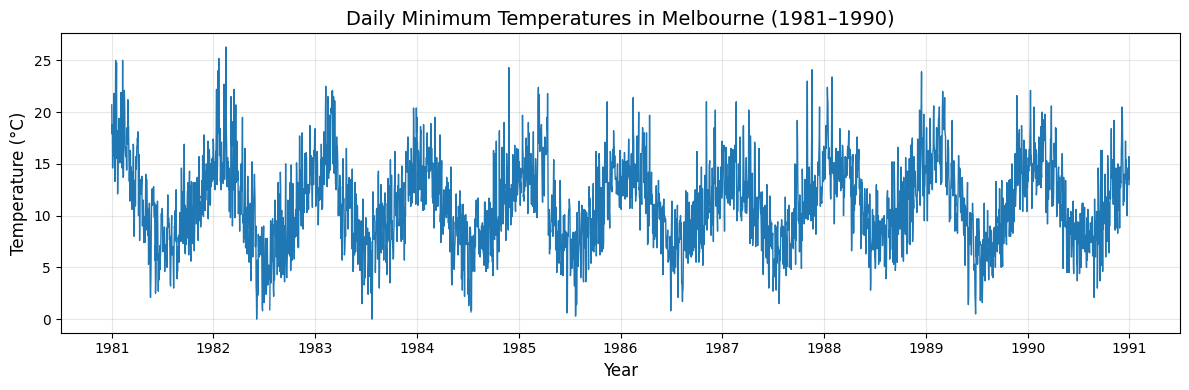

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["Temp"], linewidth=1)
plt.title("Daily Minimum Temperatures in Melbourne (1981–1990)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

👉 **Observation:**  
We see **clear repeating cycles** every year: temperatures rise and fall in a regular pattern.  
- Summers (peaks) are warmer.  
- Winters (troughs) are colder.  
- This indicates **strong yearly seasonality**.  

**Step 2: Zoom into One Year**
To see this seasonal cycle in more detail, let’s zoom into **1981** with monthly ticks.

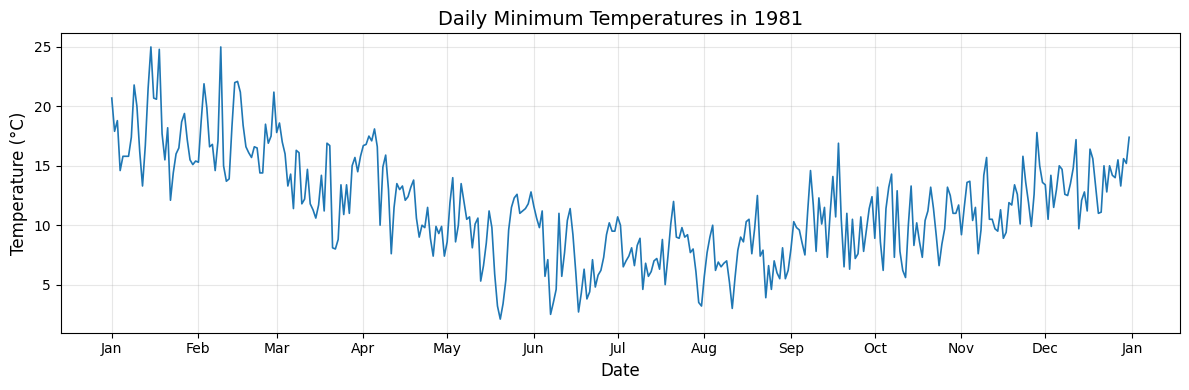

In [13]:
plt.figure(figsize=(12, 4))
plt.plot(df.loc["1981"].index, df.loc["1981"]["Temp"], linewidth=1.2)
plt.title("Daily Minimum Temperatures in 1981", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


**Observation:**  
Within 1981, we again see the **summer peak → winter dip → summer rise** cycle.  
This confirms the **annual periodicity** seen in the full dataset.  

**Step 3: Smoothing for Clarity**

Daily data is noisy (lots of ups and downs).  
To better see the **underlying seasonal pattern**, let’s add a **30-day rolling mean**.

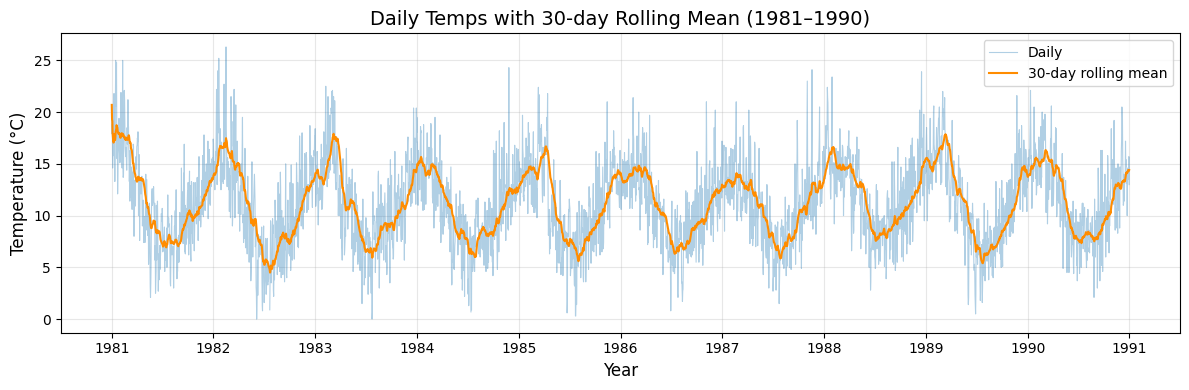

In [ ]:
plt.figure(figsize=(12, 4))
plt.plot(df.index, df["Temp"], alpha=0.35, linewidth=0.8, label="Daily")
plt.plot(df["Temp"].rolling(window=30, min_periods=1).mean(),
         linewidth=1.5, color="darkorange", label="30-day rolling mean")
plt.title("Daily Temps with 30-day Rolling Mean (1981–1990)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Temperature (°C)", fontsize=12)

ax = plt.gca()
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

**Observation:**  
The rolling mean highlights the **annual seasonality** even more clearly:
- Temperatures rise and fall in a **regular cycle** each year.  
- The amplitude (difference between summer and winter) stays fairly consistent across years.  
- There is **no obvious long-term upward or downward trend**.

**Reflection**
- Do we see **seasonal cycles**? → ✅ Yes, yearly.  
- Do we see a **trend across the decade**? → ❌ Not really.  
- How much **daily variability** is there compared to the seasonal pattern? → Quite a lot, but the seasonal signal dominates.

👉 This seasonal structure is exactly why we will frame our problem using **sliding windows**: to give the model enough context to learn these repeating patterns.

---

### **3. Framing Time Series as Supervised Learning**

**Why Framing Matters:**
In Project 7, we worked with **sensor sequences** and predicted an **activity class**.  

Mathematically:

- **Project 7:**  
  $X = [x_1, x_2, \dots, x_T] \;\;\longrightarrow\;\; y \in \{\text{Walking}, \text{Sitting}, \dots\}$  

Now, in Project 8, we are shifting perspective:  
Instead of predicting a **class label**, we want to predict the **next numeric value** in the sequence.

- **Project 8:**  
  $X = [T_1, T_2, \dots, T_n] \;\;\longrightarrow\;\; y = T_{n+1}$  

**Key Idea**
- We convert a time series into a **supervised learning dataset** using **sliding windows**.  
- Each input $X$ is a fixed-length sequence of past observations.  
- The target $y$ is simply the **next observation**.  

👉 This is called **lag-based framing**.

**A Toy Example:**
Suppose we use a **window size = 3** (look back at the past 3 days):

| Day | Temp ($T$) | Input $X = [T_{t-3}, T_{t-2}, T_{t-1}]$ | Target $y = T_t$ |
|-----|------------|----------------------------------------|------------------|
| 4   | 14.6       | [20.7, 17.9, 18.8]                     | 14.6             |
| 5   | 15.8       | [17.9, 18.8, 14.6]                     | 15.8             |
| 6   | 15.8       | [18.8, 14.6, 15.8]                     | 15.8             |

Notice how each new row “slides” forward one day.

**Implementation: Create Sliding Windows (Toy Data)**

In [ ]:
import numpy as np

def create_sequences(values, window_size=3):
    """
    Convert a 1D array into (X, y) pairs using a sliding window.
    X shape: (num_samples, window_size)
    y shape: (num_samples,)
    """
    X, y = [], []
    for i in range(window_size, len(values)):
        X.append(values[i-window_size:i])  # previous window_size values
        y.append(values[i])                # next value
    return np.array(X), np.array(y)

# Example with a short sequence
toy_values = [20.7, 17.9, 18.8, 14.6, 15.8, 15.8]
X, y = create_sequences(toy_values, window_size=3)

print("Inputs (X):\n", X)
print("Targets (y):\n", y)

Inputs (X):
 [[20.7 17.9 18.8]
 [17.9 18.8 14.6]
 [18.8 14.6 15.8]]
Targets (y):
 [14.6 15.8 15.8]


**Applying to the Real Temperature Dataset**

Now let’s apply the same logic to our **Melbourne daily minimum temperature series**.  
We’ll use a **7-day sliding window** (one week of past data → predict next day).

In [17]:
# Use the full temperature column from the dataset
temps = df["Temp"].values

# Create supervised pairs with a 7-day window
X_real, y_real = create_sequences(temps, window_size=7)

print("Shape of inputs (X):", X_real.shape)
print("Shape of targets (y):", y_real.shape)

# Show the first 5 samples
for i in range(5):
    print(f"X[{i}] = {X_real[i]}, y[{i}] = {y_real[i]}")


Shape of inputs (X): (3643, 7)
Shape of targets (y): (3643,)
X[0] = [20.7 17.9 18.8 14.6 15.8 15.8 15.8], y[0] = 17.4
X[1] = [17.9 18.8 14.6 15.8 15.8 15.8 17.4], y[1] = 21.8
X[2] = [18.8 14.6 15.8 15.8 15.8 17.4 21.8], y[2] = 20.0
X[3] = [14.6 15.8 15.8 15.8 17.4 21.8 20. ], y[3] = 16.2
X[4] = [15.8 15.8 15.8 17.4 21.8 20.  16.2], y[4] = 13.3


**Interpreting the Output**

- The shapes tell us:
  - `X.shape = (3643, 7)` → we created **3643 input sequences**, each made of **7 consecutive days**.  
  - `y.shape = (3643,)` → each sequence predicts **1 target value** (the next day).  

- The first few rows show exactly how this framing works:
  - **Example 1:**  
    $X_0 = [20.7, 17.9, 18.8, 14.6, 15.8, 15.8, 15.8]$  
    $y_0 = 17.4$  
    → “If the last 7 days looked like this, predict 17.4 tomorrow.”

  - **Example 2:**  
    $X_1 = [17.9, 18.8, 14.6, 15.8, 15.8, 15.8, 17.4]$  
    $y_1 = 21.8$  
    → “If the last 7 days looked like this, predict 21.8 tomorrow.”

- Notice how the **window slides forward by 1 day** each time.  
- This is the same principle as our toy example — now scaled up to the full dataset.

**Reflection**
- Why does this framing matter?  
  → Because LSTMs cannot “understand” raw time series directly. They need the series **segmented into input-output pairs** for supervised learning.  

- What is the intuition?  
  → We are teaching the model: *“If the last 7 days looked like this, the next day will look like that.”*  

- How does this connect to Project 7?  
  → Same structure: a sequence in → something predicted out.  
  - Project 7: Sequence → Activity class (classification).  
  - Project 8: Sequence → Next temperature (regression).  

📌 This supervised framing is the **bridge** that allows us to apply deep learning models to time series forecasting.

---

### **4. Train/Test Split (Time-Aware)**

**Why This Matters (different from Project 7)**
In Project 7 we sometimes used **random splits** because activities were i.i.d. at the sequence level.  
For **time series**, random splits cause **data leakage**:

- If tomorrow’s value (test) comes from the **same season** as today’s value (train) and we shuffle them, the model “peeks into the future.”
- This inflates test performance and gives us **over-optimistic** results.

👉 For forecasting, we **must respect temporal order**: train on *earlier* years, test on *later* years.

**Plan**
- We’ll use the **first 8 years** for training and the **last 2 years** for testing.  
- We’ll **split before scaling and before creating windows** to avoid leakage across the boundary.

We’ll also visualize the split so we can **see** which years are in train vs. test.

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Choose a split date so we get ~8 years train (1981–1988) and 2 years test (1989–1990)
split_date = pd.Timestamp("1989-01-01")

# Time-aware split
df_train = df.loc[: split_date - pd.Timedelta(days=1)]
df_test  = df.loc[split_date :]

print("Train period:", df_train.index.min().date(), "→", df_train.index.max().date(), "| rows:", len(df_train))
print("Test  period:", df_test.index.min().date(),  "→", df_test.index.max().date(),  "| rows:", len(df_test))


Train period: 1981-01-01 → 1988-12-30 | rows: 2920
Test  period: 1989-01-01 → 1990-12-31 | rows: 730


**Visualizing Train vs. Test Periods**
Let’s plot the series again and **color the time spans** for train (left) and test (right).

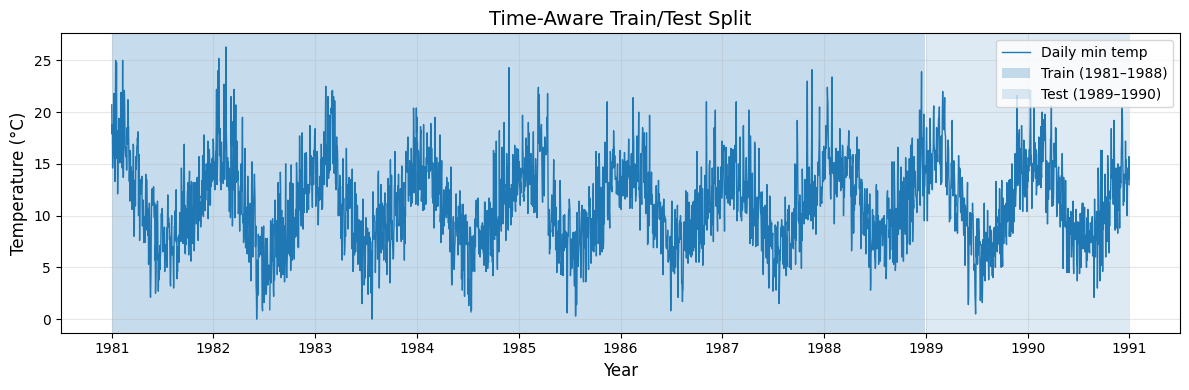

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4))

ax.plot(df.index, df["Temp"], linewidth=1, label="Daily min temp")

# Shade regions
ax.axvspan(df_train.index.min(), df_train.index.max(), alpha=0.25, label="Train (1981–1988)")
ax.axvspan(df_test.index.min(),  df_test.index.max(),  alpha=0.15, label="Test (1989–1990)")

# Formatting
ax.set_title("Time-Aware Train/Test Split", fontsize=14)
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Temperature (°C)", fontsize=12)
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.grid(alpha=0.3)
ax.legend()
fig.tight_layout()
plt.show()

**What we just ensured**

- **No future information leaks into training.**  
  Imagine we allowed random shuffling: the model might see a **1989 winter day** in training and then get evaluated on a **1988 winter day** in testing.  
  → This is cheating because the model already saw very similar “future” conditions.  
  By splitting chronologically (1981–1988 train, 1989–1990 test), we guarantee the model only sees **the past** while learning.

- **Evaluation now mirrors the real forecasting task.**  
  In the real world, we always ask: *“Given what happened up until today, can we predict tomorrow?”*  
  That means our evaluation must also respect time order.  
  → If the model performs well on the 1989–1990 test set, we gain confidence it can **generalize to unseen future years.**


**Preparing for Windows (no leakage across the boundary)**

There’s another subtle but critical point:  
When we create **sliding windows** (e.g., 7 past days → next day), we must build them **separately** for train and test.  

- If we created windows on the full dataset first, some windows would **cross the 1988→1989 boundary**.  
- That would let information from early 1989 (test) sneak into late 1988 (train).  
- Even though it seems small, this type of leakage can make results misleading.

👉 To avoid this, we first split the series into train/test and *then* apply our `create_sequences` function separately to each part.

In [ ]:
# Reuse the helper from Section 3
# def create_sequences(values, window_size=3): ...

window_size = 7  # one week of history → predict next day

X_train, y_train = create_sequences(df_train["Temp"].values, window_size=window_size)
X_test,  y_test  = create_sequences(df_test["Temp"].values,  window_size=window_size)

print("Train X shape:", X_train.shape, "| y shape:", y_train.shape)
print("Test  X shape:", X_test.shape,  "| y shape:",  y_test.shape)

Train X shape: (2913, 7) | y shape: (2913,)
Test  X shape: (723, 7) | y shape: (723,)


**Reflection: Why Time-Aware Splits Matter**

Think back to **Project 7 (HAR dataset)**:  
- We could safely use random splits there because each activity sequence was independent of the others.  
- "Walking" on one person in the test set didn’t depend on "Walking" from the training set.

But here in **time series**, things are very different:  
- **Yesterday’s temperature influences today’s temperature.**  
- If we shuffle days randomly, the model might see **January 1990** during training and then be tested on **December 1989**.  
- That’s like letting the model peek into the future — clearly unrealistic.

**Guarding Against Leakage**

- By splitting **chronologically** (e.g., 1981–1988 for training, 1989–1990 for testing), we ensure the model only learns from the **past**.  
- The test set truly represents the **unknown future** — just like when we deploy models in real life.

**Why Windows Must Respect the Split**

- Our sliding windows are like "mini training examples":  
  $X = [T_{t-6}, T_{t-5}, \dots, T_{t}], \quad y = T_{t+1}$

- If we build these windows across the full dataset **before splitting**, some windows will cross the boundary (late 1988 feeding into early 1989).  
- This would secretly give the training process information about the test period.  
- Even if it’s only one or two days, this kind of **data leakage** can inflate our model’s performance and give us false confidence.

**Key Takeaway**

In time series tasks:  
1. **Always split by time, not randomly.**  
2. **Always build windows separately for train and test.**  

This way, our model’s evaluation reflects the **true challenge**:  
predicting the **future** using only the **past**.

---

### **5. Scaling & Normalization**

**Why Scaling Matters**
When we train a neural network, the raw values we feed into it have a direct effect on how well the model learns.  
If the inputs are very large or very small, the network’s **weights and gradients** can behave unpredictably.  
For example, if we trained on raw temperatures in degrees Celsius (values around 10–30) alongside another variable in the hundreds (say rainfall in millimeters), the larger numbers would dominate the learning process.  

This domination leads to two problems:
1. The model pays more attention to features with bigger numeric ranges, even if they are not actually more important.  
2. During training, the **gradients** that update the model’s weights can either shrink too quickly (vanishing gradients) or grow uncontrollably (exploding gradients). Both make learning unstable.

Scaling helps prevent these issues.  
By transforming all inputs into a **common range**, we give every feature an equal chance to influence the model, and we keep the gradients at healthy magnitudes.  
This leads to **faster and more stable training**.

**Difference from Project 7**
In **Project 7**, we worked with the Human Activity Recognition dataset. Each input sequence was not just one number per timestep, but a block of **128 time steps × 9 features** (accelerometer and gyroscope axes).  
Since every sensor axis had its own natural range (e.g., acceleration could be between –1 and +1, gyroscope values could be much larger), we applied **standardization per feature**. This ensured that all nine signals were on the same scale before they entered the RNN.

In **Project 8**, things are simpler. We only have **one feature**: daily minimum temperature.  
Because this is univariate data, we do not need to standardize multiple channels separately. Instead, we can rescale this single series using:
- **MinMax scaling**: shrinks all values into the range $[0, 1]$.  
- **Standard scaling**: shifts values to have mean $0$ and standard deviation $1$.  

Here, we will use **MinMax scaling** because it keeps the values in an intuitive range (between 0 and 1), making it easier to interpret what the network sees.

**Avoiding Data Leakage**
It is extremely important that we **fit the scaler only on the training set**.  
If we let the scaler see the full dataset, it would learn the maximum and minimum temperatures of the **entire 10-year period**.  
That means while training on 1981–1988, the transformation would already "know" something about 1989–1990.  

This is called **data leakage**: the model indirectly has access to future information that it should not have.  
It’s a subtle but very common mistake in time series modeling.  
If leakage happens, our evaluation on the test set will be misleading, because the model has already been influenced by the test data.

By fitting the scaler **only on the training years (1981–1988)** and then applying that same transformation to the test years (1989–1990), we mimic the real-world scenario:  
- At training time, we only know the data we have seen so far.  
- At testing (or deployment), we apply the same transformation rules to new, unseen data.  

This ensures our evaluation truly reflects how well the model generalizes to the future.

**Scaling Train & Test Separately**

In [27]:
from sklearn.preprocessing import MinMaxScaler

# Initialize scaler
scaler = MinMaxScaler(feature_range=(0, 1))

# Fit only on training set
scaler.fit(df_train[["Temp"]])

# Transform train and test
train_scaled = scaler.transform(df_train[["Temp"]])
test_scaled  = scaler.transform(df_test[["Temp"]])

print("Train scaled shape:", train_scaled.shape)
print("Test scaled shape:", test_scaled.shape)
print("First 5 scaled train values:", train_scaled[:5].flatten())


Train scaled shape: (2920, 1)
Test scaled shape: (730, 1)
First 5 scaled train values: [0.78707224 0.68060837 0.7148289  0.55513308 0.60076046]


**Reflection**

Think carefully about what would happen if we scaled the entire dataset before splitting it.  
- The maximum temperature in 1990 (the test period) would directly affect how the 1981–1988 values are scaled.  
- This means the training process would already "anticipate" future data.  

Even though this might not look like a big deal at first glance, it completely breaks the principle of fair evaluation.  
In real life, we never know the range of future values — we only know the past.  

By fitting the scaler on the **training set only**, we ensure that our test set remains a true **simulation of the future**, and our evaluation remains honest.


**Visualizing the Effect of Scaling**

Reading about scaling is one thing, but it becomes much clearer when we actually **see what it does**.  
Remember: the raw temperature values are in degrees Celsius, ranging roughly between 5°C and 25°C.  
After applying MinMax scaling, all of these values are compressed into the range $[0, 1]$.  

This doesn’t change the *pattern* of the data (the ups and downs, the seasonality), but it does change the *scale*.  
By doing so, the model sees inputs that are numerically well-behaved and easier to learn from.

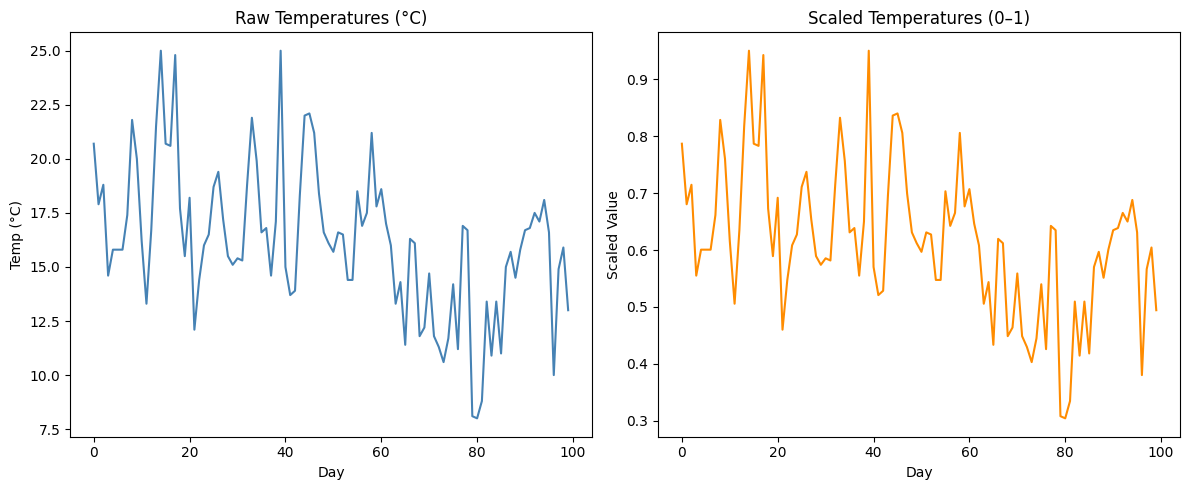

In [28]:
import matplotlib.pyplot as plt

# Pick the first 100 days for clarity
days = range(100)

plt.figure(figsize=(12, 5))

# Raw values
plt.subplot(1, 2, 1)
plt.plot(df_train["Temp"].values[:100], color="steelblue")
plt.title("Raw Temperatures (°C)")
plt.xlabel("Day")
plt.ylabel("Temp (°C)")

# Scaled values
plt.subplot(1, 2, 2)
plt.plot(train_scaled[:100], color="darkorange")
plt.title("Scaled Temperatures (0–1)")
plt.xlabel("Day")
plt.ylabel("Scaled Value")

plt.tight_layout()
plt.show()


**Reflection**

Notice how the two plots have **the same shape**: peaks, valleys, and repeating cycles remain unchanged.  
The difference lies in the **scale of the y-axis**:  
- On the left, values range between 10 and 25.  
- On the right, the same values now fit neatly between 0 and 1.  

This is exactly what we want:  
- The **patterns** (what the network must learn) are preserved.  
- The **scale** (which could make optimization difficult) is normalized.  

Scaling therefore improves training without altering the underlying signal.

---

### **6. Sliding Window Function**

**Why Sliding Windows?**

Neural networks like RNNs and LSTMs do not consume a whole time series at once.  
Instead, we break the series into **shorter overlapping windows**.  
Each window represents a short history of the past, and the model learns to use this history to predict the next value.

Formally:

- Choose a window size $n$ (for example, 7 days).  
- Use those $n$ values as input $X$.  
- Predict the next value $y = T_{n+1}$.

So if the series is daily minimum temperature, a 7-day window means:
> “Look at the past 7 days → predict tomorrow’s temperature.”

**The Sliding Mechanism**

Imagine we have this tiny sequence of 10 days:

$$
[20.7,\; 17.9,\; 18.8,\; 14.6,\; 15.8,\; 15.8,\; 15.8,\; 17.4,\; 21.8,\; 20.0]
$$

With `window_size = 3`:
- First window: $X = [20.7, 17.9, 18.8] \;\;\longrightarrow\;\; y = 14.6$  
- Second window: $X = [17.9, 18.8, 14.6] \;\;\longrightarrow\;\; y = 15.8$  
- Third window: $X = [18.8, 14.6, 15.8] \;\;\longrightarrow\;\; y = 15.8$  
- … and so on.

The window **slides forward one step at a time**, always using the last $n$ days to predict the next one.

This creates many training examples from one continuous series.

**Visual Intuition**
```text
Day:     T1     T2     T3     T4     T5     T6     T7     T8
Window:  [T1,    T2,    T3]     → y = T4
         [T2,    T3,    T4]     → y = T5
         [T3,    T4,    T5]     → y = T6
```

Notice how the windows overlap: each new window shares most of its values with the previous one.

**Implementation**

We’ll now implement a function that turns a series into sliding windows.

In [29]:
import numpy as np

def create_sliding_windows(series, window_size=7):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i+window_size])
        y.append(series[i+window_size])
    X = np.array(X)
    y = np.array(y)
    return X.reshape((X.shape[0], X.shape[1], 1)), y.reshape((-1, 1))

# Example: apply to training set
window_size = 7
X_train, y_train = create_sliding_windows(train_scaled, window_size)
X_test,  y_test  = create_sliding_windows(test_scaled,  window_size)

print("Train X shape:", X_train.shape, "| y shape:", y_train.shape)
print("Test  X shape:", X_test.shape,  "| y shape:",  y_test.shape)
print("Example X_train[0]:", X_train[0].flatten(), "→ y:", y_train[0])


Train X shape: (2913, 7, 1) | y shape: (2913, 1)
Test  X shape: (723, 7, 1) | y shape: (723, 1)
Example X_train[0]: [0.78707224 0.68060837 0.7148289  0.55513308 0.60076046 0.60076046
 0.60076046] → y: [0.66159696]


**Reflection**

The shapes confirm what we expect:
- `X_train` has shape `(num_samples, window_size, 1)`.  
  - Each sample = one 7-day sequence.  
  - The final `1` dimension is because we only have one feature (temperature).  
- `y_train` has shape `(num_samples, 1)`.  
  - Each target is the temperature on the day after the window.

This framing step is critical:  
- Without windows, the model would just see one long stream with no clear input–output pairs.  
- With windows, we now have **many supervised learning examples**, perfectly suited for LSTMs.

Think of it as transforming one long time series into a dataset of short sequences with labels.

---

### **7. Preparing PyTorch Datasets & Loaders**

**From Project 7 to Project 8 — what stays the same, what changes**

In Project 7 (HAR), we fed the RNN **sequences** and predicted a **label**. We organized tensors in **time-first** layout `(seq_len, batch, input_size)` because that matches the recurrence story: time flows step by step, and the hidden state travels with it.

In Project 8 (LSTM for forecasting), we will **still** feed sequences — but this time, each sequence is a **sliding window of temperatures**, and the target is the **next day’s temperature** (a number). So the learning setup is still “sequence in → prediction out”; only the **task type** changed (classification → regression) and the **data source** (sensor windows vs. temperature windows).

**About input shapes (time-first vs batch-first)**

Both `nn.RNN` and `nn.LSTM` in PyTorch can accept **either** layout:

- **Time-first (default):** `(seq_len, batch, input_size)`  
  This mirrors the math of recurrence and is great for *understanding* how sequence models work.
- **Batch-first (opt-in):** `(batch, seq_len, input_size)` (set `batch_first=True`)  
  This is convenient when we think “one row per training example”, like our sliding windows table.

> **Our teaching choice**  
> In Project 7 we used **time-first** to help us “see” the time flow. Now that we understand the architecture, we will use **batch-first** for convenience: it matches how we built windows (each row = one example).  
> Under the hood, PyTorch handles either layout appropriately — changing the *layout* does **not** change the math inside the LSTM.

**Quick reference:**
```python
# Time-first (default)
nn.RNN(input_size=1, hidden_size=64)              # expects (seq_len, batch, input_size)
nn.LSTM(input_size=1, hidden_size=64)             # expects (seq_len, batch, input_size)

# Batch-first (explicit)
nn.RNN(input_size=1, hidden_size=64, batch_first=True)   # expects (batch, seq_len, input_size)
nn.LSTM(input_size=1, hidden_size=64, batch_first=True)  # expects (batch, seq_len, input_size)
```

If we ever need to switch layouts on a batch tensor:

```python
# (batch, seq_len, input_size)  →  (seq_len, batch, input_size)
xb_seq_first = xb.permute(1, 0, 2)
```

In [31]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# 1) NumPy → PyTorch tensors
X_train_t = torch.tensor(X_train, dtype=torch.float32)  # (N_train, seq_len, 1)
y_train_t = torch.tensor(y_train, dtype=torch.float32)  # (N_train, 1)

X_test_t  = torch.tensor(X_test,  dtype=torch.float32)  # (N_test,  seq_len, 1)
y_test_t  = torch.tensor(y_test,  dtype=torch.float32)  # (N_test,  1)

# 2) Wrap in datasets
train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

# 3) Build DataLoaders (batch-first batches by default)
BATCH_SIZE = 64
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)   # shuffle only for train
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

# 4) Inspect a batch
xb, yb = next(iter(train_loader))
print("Batch X shape (batch-first):", xb.shape)  # expected: (batch, seq_len, input_size) e.g., (64, 7, 1)
print("Batch y shape:", yb.shape)                # expected: (batch, 1)

# If a model expects time-first (e.g., batch_first=False), we can permute:
xb_seq_first = xb.permute(1, 0, 2)  # (seq_len, batch, input_size)
print("Permuted X for time-first model:", xb_seq_first.shape)


Batch X shape (batch-first): torch.Size([64, 7, 1])
Batch y shape: torch.Size([64, 1])
Permuted X for time-first model: torch.Size([7, 64, 1])


**How `permute` works (with a tiny tensor)**

`permute` **reorders dimensions** of a tensor. With sequence models we mostly toggle between:  
- **batch-first:** `(batch, seq, feat)`  
- **time-first:** `(seq, batch, feat)`

Let’s build a tiny 3-D tensor and watch what moves.

In [ ]:
import torch

# Make a tiny tensor with obvious indexing:
# B=2 batches, S=3 timesteps, F=4 features  → shape (2, 3, 4)
t = torch.arange(2*3*4).view(2, 3, 4)
print("Original shape (B,S,F):", t.shape)
print(t)  # values 0..23 so we can track positions

# Take one element in batch-first indexing:
# e.g., batch=1, step=2, feat=3
print("t[1, 2, 3] =", t[1, 2, 3].item())

# Convert to time-first: (S, B, F)
t_timefirst = t.permute(1, 0, 2)
print("Time-first shape (S,B,F):", t_timefirst.shape)

# The same value must now be found at indices [step, batch, feat] → [2, 1, 3]
print("t_timefirst[2, 1, 3] =", t_timefirst[2, 1, 3].item())

# Back to batch-first (should recover original):
t_back = t_timefirst.permute(1, 0, 2)
print("Back to batch-first shape:", t_back.shape)
print("Restored equals original?", torch.equal(t_back, t))

Original shape (B,S,F): torch.Size([2, 3, 4])
tensor([[[ 0,  1,  2,  3],
         [ 4,  5,  6,  7],
         [ 8,  9, 10, 11]],

        [[12, 13, 14, 15],
         [16, 17, 18, 19],
         [20, 21, 22, 23]]])
t[1, 2, 3] = 23
Time-first shape (S,B,F): torch.Size([3, 2, 4])
t_timefirst[2, 1, 3] = 23
Back to batch-first shape: torch.Size([2, 3, 4])
Restored equals original? True


: 

**What we learn from this demo**

- `(batch, seq, feat) → (seq, batch, feat)` is simply **relabeling axes**, not recomputing values.  
- The number `t[1, 2, 3]` is *the same scalar* you find at `t_timefirst[2, 1, 3]` after swapping dimensions.

> 📝 Practical tip:  
> `permute` changes the **view/strides** of a tensor. If you later need to call `.view(...)` (rare in our workflow), first call `.contiguous()`. Example:  
> `xb.permute(1, 0, 2).contiguous().view(...)`

**Connecting this to our loaders**

- Our `DataLoader` yields **batch-first** batches by design: `xb.shape = (batch, seq, features)`, e.g., `(64, 7, 1)`.  
- If we build our LSTM with `batch_first=True`, we can pass `xb` **as is**.  
- If we ever use a time-first model (`batch_first=False`), we convert once per batch:

```python
# batch-first → time-first
xb_timefirst = xb.permute(1, 0, 2)   # (seq, batch, feat)
```

Either way, we’re feeding the same information to the network; we’re just arranging the axes the way the layer expects.

**(Optional) Mini shape check with a tiny LSTM**
We won’t train here (that’s for NB02), but seeing shapes flow through an LSTM once helps cement the idea.

- With **batch-first LSTM**, we pass `xb` as is.  
- With **time-first LSTM**, we permute to `(seq_len, batch, input_size)` first.

In [32]:
import torch.nn as nn

seq_len = xb.shape[1]
input_size = xb.shape[2]
hidden_size = 16

# Batch-first LSTM
lstm_bf = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True)
out_bf, (h_bf, c_bf) = lstm_bf(xb)  # xb: (batch, seq_len, input_size)
print("Batch-first LSTM → out:", out_bf.shape, "| h:", h_bf.shape, "| c:", c_bf.shape)

# Time-first LSTM
lstm_tf = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=False)
xb_tf = xb.permute(1, 0, 2)  # (seq_len, batch, input_size)
out_tf, (h_tf, c_tf) = lstm_tf(xb_tf)
print("Time-first LSTM  → out:", out_tf.shape, "| h:", h_tf.shape, "| c:", c_tf.shape)


Batch-first LSTM → out: torch.Size([64, 7, 16]) | h: torch.Size([1, 64, 16]) | c: torch.Size([1, 64, 16])
Time-first LSTM  → out: torch.Size([7, 64, 16]) | h: torch.Size([1, 64, 16]) | c: torch.Size([1, 64, 16])


**What we learn from this quick peek:**
- The internal LSTM computations are the same; only the **input layout** differs.
- `out` contains outputs for all time steps; `h`/`c` are the final hidden/cell states per layer.

**Reflection — why do we bother with sliding windows and loaders?**
If we tried to predict tomorrow from **just yesterday**, we would throw away valuable context (short warm/cool spells, weekly rhythms, seasonal cues).  
By using **windows**, we give the model a *memory* of the recent past.  
By using **loaders**, we organize that memory into batches the model can learn from efficiently, with a clear shape convention:
- **In this project**, we’ll favor **batch-first** `(batch, seq_len, input_size)` for convenience.
- If we ever need **time-first**, we know exactly how to permute.

This clarity about shapes and layouts lets us focus on what matters next: **building and evaluating our forecasting models**.

---

### **8. Recap & Looking Ahead**

**What we accomplished in this notebook**
- We **loaded and explored** the Melbourne daily minimum temperature series and **confirmed clear yearly seasonality**.
- We **respected time** by doing a **chronological train/test split** (1981–1988 → train, 1989–1990 → test), so no future information leaks into training.
- We **scaled** the data (fit on train only, transform train + test) to make optimization stable and fair.
- We **framed forecasting as supervised learning** with **sliding windows**:  
  for a window size of 7, each example is 7 past days → predict the next day.
- We **built PyTorch datasets and loaders** from these windows and clarified **input layouts**:  
  we’ll use **batch-first** `(batch, seq_len, input_size)` in this project, and we know how to switch to **time-first** if needed with `permute`.

Together, we turned a raw time series into a **clean, learnable dataset** of sequences and targets that our models can consume.

**How this connects to Project 7**
In Project 7, we fed **sequence data** (128×9 sensor segments) to an RNN for **classification**.  
Here, we’re again feeding **sequence data**, but our target is **numeric** (regression): the **next temperature**.  
The pipeline is the same spirit—**sequence in → prediction out**—with a different objective.

**What’s next (NB02)**
In **Notebook 2**, we will:
1. **Build and train a Vanilla RNN** as a **baseline** on our sliding windows (CPU-only, quick training).
2. **Evaluate** with metrics like **MAE/RMSE**, and **invert scaling** to report errors back in °C.
3. **Visualize predictions vs. actuals** (lines over time) so we can *see* where the model succeeds or fails.

This baseline will set the stage for **Notebook 3 & 4**, where we’ll introduce **LSTM/GRU** to tackle longer temporal dependencies and analyze why they help.

**Reflection (for us)**
**What limitations do we expect from a Vanilla RNN on this forecasting task?**  
Let’s think aloud:
- **Long-range dependency challenge:** a simple RNN tends to “forget” information over longer spans (vanishing gradients), so it may struggle to leverage seasonal structure beyond short windows.
- **Recency bias:** predictions may hug recent values and **lag** behind rapid changes (e.g., sudden cold snaps).
- **Capacity vs. stability tradeoff:** deeper or larger RNNs can memorize more patterns but can also be harder to train and tune without gating.

These are exactly the pain points that **LSTM/GRU** are designed to address. In NB02, we’ll quantify the baseline; in NB03–NB04, we’ll improve and explain *why* the gated architectures work better.
